# Оценки наименьших квадратов. Гауссовская линейная модель

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (15, 6)
rcParams['image.cmap'] = 'viridis'

![Задание](../img/p8_1.png)

In [14]:
data = pd.read_csv('../../forestfires.csv')

# Индикатор летнего месяца
summer_months = ['jun','jul','aug']
data.insert(2, 'is_summer', [int(i in summer_months) for i in data['month']])

data.drop('month', axis=1, inplace=True)
data.drop('day', axis=1, inplace=True)

# Свободный член
data.insert(2, 'b', 1)
data.head()

,X,Y,b,is_summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,1,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,1,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,1,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,1,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,1,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Напишем класс линейной модели:

In [28]:

class My_linear_model():
    def __init__(self):
        pass
    
    def fit(self, X,y):
        tmp = np.dot(X.T, X)
        x_product = np.dot(np.linalg.inv(tmp), X.T)
        self.coeffs = np.dot(x_product, y)
        
    def predict(self, X):
        return np.dot(X, self.coeffs)

* Разобьем выборку случайным образом на 2 части;

* Обучимся на 70% выборки, протестируемся на 30%;

* Выведем среднеквадратичную ошибку на тесте;

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = data.ix[:,:-1], data.ix[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

my_lm = My_linear_model()
my_lm.fit(X_train, y_train)
y_pred = my_lm.predict(X_test)
print("Mse: ", mean_squared_error(y_test, y_pred))

Mse:  777.682789603


## Преобразование таргетной переменной

---

Преобразуем таргетную переменную $area$ по формуле:

$$new\_area = log(area + c)$$

Параметр $c$ подберем экспериментально.

Эксперимент такой:

* для фиксированного разбиения выборки на $train/test$, обучаем модель на трансформированных значениях $area$ на $train$;
* затем предсказываем значения на $test$;
* трансформируем предсказанные значения обратно и считаем среднеквадратичную ошибку с правильными ответами.

Таким образом находим $c$, преобразование с которым дает наименьшую ошибку.


In [131]:
def score_for_c(c, X_train, X_test, y_train, y_test):
    
    back_transf = lambda x: np.exp(x)-c
    new_y = np.log(y_train.values + c)
    my_lm.fit(X_train, new_y)
    y_pred = my_lm.predict(X_test)
    
    return mean_squared_error(y_test, back_transf(y_pred))

In [132]:
c_results = []
x_range = range(1,101)

for c in x_range:
    c_results.append(score_for_c(c, X_train, X_test, y_train, y_test))

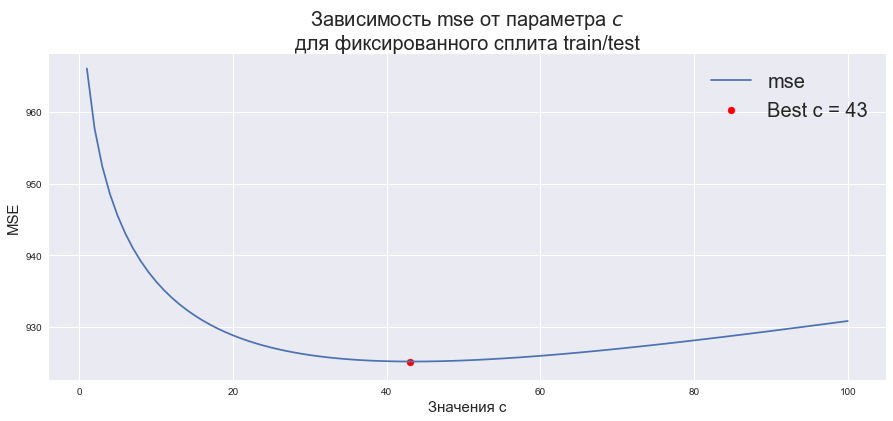

In [133]:
plt.plot(x_range, c_results, label = 'mse')
plt.scatter(np.argmin(c_results)+1, min(c_results), c='r', label="Best c = "+str(np.argmin(c_results)+1))
plt.xlabel("Значения c", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.legend(fontsize=20)
plt.title("Зависимость mse от параметра $c$\nдля фиксированного сплита train/test", fontsize=20)
plt.show()

## Множество рандомных фитов

А теперь просто будем каждый раз генерировать случайные разбиения и смотреть на mse для выбранного параметра $c=43$

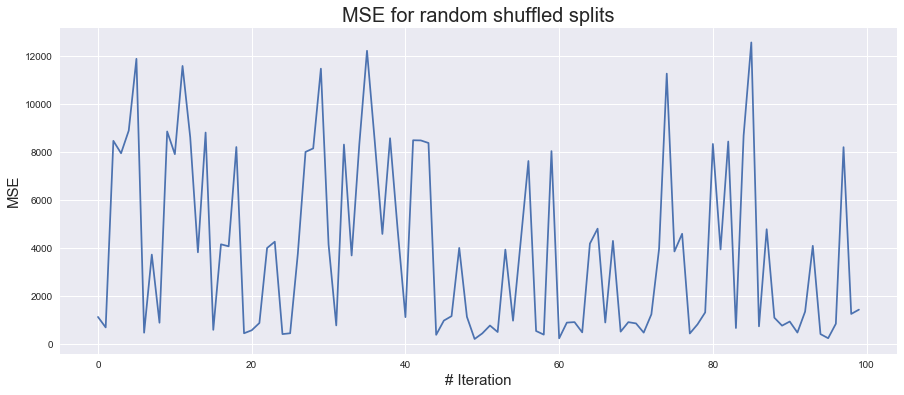

In [134]:
random_results = []
c = 43

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    random_results.append(score_for_c(c, X_train, X_test, y_train, y_test))

plt.plot(range(100), random_results)
plt.title("MSE for random shuffled splits", fontsize=20)
plt.ylabel("MSE", fontsize=15)
plt.xlabel("# Iteration", fontsize=15)
plt.show()

## Выводы

* В данных много нулей -- 247/517, может от этого модель не может уловить некоторую общность происходящего.
* Приведенное преобразование призвано уменьшить зазор на гистограмме между большими по сравнению с нулями значениями y, т.е. немного сгладить, выровнять распределение y. Но для каждого рандомного деления это распределение получается разное и потому невозможно подобрать универсальный самый лучший параметр с.